# ***Подготовка входных данных***

In [48]:
!ls

balance  balance.zip  dee  dee.zip  ecoli  ecoli.zip  sample_data


In [49]:
!unzip "dee.zip" -d "dee"

Archive:  dee.zip
replace dee/dee.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [50]:
def load_keel(file_path):
    file_path = Path(file_path)
    return KeelParser()(file_path.read_text())

In [51]:
import re
from pathlib import Path
from pandas import DataFrame, Categorical, to_numeric
import numpy as np
from functools import partial
from sklearn.preprocessing import LabelEncoder

class DataScheme:
    def __init__(self, data_name, attributes, inputs, outputs, X, y):
        self.data_name = data_name
        self.inputs = inputs
        self.outputs = outputs
        self.attributes = attributes
        self.X = X
        self.y = y



class KeelParser:
    def __call__(self, data):
        self.data = data

        data_name = self.get_data_name()
        attributes = self.get_attributes()
        inputs = self.get_inputs()
        outputs = self.get_outputs()
        data_frame = self.get_data()
        data_frame.columns = [*inputs, *outputs]
        X = np.array(data_frame[inputs])
        y = np.array(data_frame[outputs]).ravel()

        if len(outputs) > 1:
            raise Exception('Multiple outputs in dataset not yet supported')
        if attributes[outputs[0]][0] == 'nominal':
            y = Categorical(
                y,
                ordered=False,
                categories=attributes[outputs[0]][1]
            ).codes
        elif attributes[outputs[0]][0] == 'real':
            y = np.array(y, dtype=float)
        return DataScheme(data_name, attributes, inputs, outputs, X, y)

    def get_data_name(self):
        """
        Функция для получения названия набора данных
        :return:
        """
        parsed = re.search(r'^@relation\s+(\S+)$', self.data, re.MULTILINE)
        return parsed.group(1)

    def get_attributes(self):
        """
        Функция для получения описаний входных и выходных параметров
        набора данных
        :return:
        """
        attributes = dict()
        if "Attribute" in self.data:
            parsed = re.findall(r'^@Attribute\s+(.+)$', self.data,
                                re.MULTILINE)
        else:
            parsed = re.findall(r'^@attribute\s+(.+)$', self.data,
                                re.MULTILINE)

        for att in parsed:
            if '{' in att:
                name = att[:att.index('{')].strip()
                att = att[att.index('{'):]
                for char in '{}':
                    att = att.replace(char, '')
                att = att.replace(" ", "")
                att = att.split(',')
                attributes[name] = ['nominal', att]
            else:
                if 'real' in att or 'integer' in att:
                    name = att[:att.index(' ')]
                    att = att[att.index(' ') + 1:]
                    att_type = att[:att.index('[')].strip()
                    att = att[att.index('['):]
                    for char in '[]':
                        att = att.replace(char, '')
                    attributes[name] = [
                        att_type, att.replace(' ', '').split(',')]
                else:
                    if 'numeric' in att:
                        att = att.split(' ')
                        attributes[att[0].strip()] = ['numeric']
                    else:
                        raise Exception(
                            f'Error during @attribute line parse: {att}')

        return attributes

    def get_inputs(self):
        """
        Функция для получения списка входных параметров набора данных
        :return:
        """
        parsed = re.search(r'^@inputs\s+(.+)$', self.data, re.MULTILINE)
        return [j.strip() for j in parsed.group(1).split(',')]

    def get_outputs(self):
        """
        Функция для получения списка выходных меток набора данных
        :return:
        """
        if "outputs" in self.data:
            parsed = re.search(r'^@outputs\s+(.+)$', self.data, re.MULTILINE)
        else:
            parsed = re.search(r'^@output\s+(.+)$', self.data, re.MULTILINE)

        return [x.strip() for x in parsed.group(1).split(',')]

    def get_data(self):
        """
        Функция для получения данных из выбранного набора
        :return:
        """
        parsed = re.search(
            r'^@data\n(.+)', self.data, flags=re.MULTILINE | re.DOTALL)
        data = np.array([
            re.split(r', ?', item) for item in parsed.group(1).splitlines()])
        dim = len(data[0])
        ys = np.copy(data[:, dim - 1])
        data[:, dim - 1] = 0
        df = DataFrame(data=data)
        df = df.apply(partial(to_numeric, errors='ignore'))
        if not (df.select_dtypes(['object']).empty):
            df.loc[:, df.dtypes == 'object'] = df.select_dtypes([
                'object'
            ]).apply(lambda x:
                     (LabelEncoder().fit_transform(x)).astype('float'))
        df[dim - 1] = df[dim - 1].astype(str)
        df[dim - 1] = ys

        return df

In [52]:
import os

FILE_PATH = '/content/dee'
MAIN_FILE_NAME = 'dee.dat'

data = load_keel('/content/dee/dee.dat')

dee = data

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

In [54]:
import tensorflow as tf

# ***Решение задачи регрессии***

In [55]:
#Определение функции, создающей модель-регрессор
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Большинство tf.keras моделей представляют собой простую последовательность слоев -
  # sequential.
  model = tf.keras.models.Sequential()

  # Описание архитектуры модели
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           

print("Defined create_model")


Defined create_model


In [56]:
def train_model(model, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Задание параметров обучения и запуск обучения
  history = model.fit(x=feature,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Получения параметров модели - линейного слоя
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch
  
  hist = pd.DataFrame(history.history)

  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined ctrain_model")

Defined ctrain_model


In [57]:
def plot_the_loss_curve(epochs, rmse):
  """График лосс-значений/эпохи"""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


Определяем X, y (my_feature, label)

In [58]:
my_feature = ([1.0, 2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0, 12.0])
my_label   = ([5.0, 8.8,  9.6, 14.2, 18.8, 19.5, 21.4, 26.8, 28.9, 32.0, 33.8, 38.2])

In [59]:
learning_rate=0.15
epochs=40
my_batch_size=12

my_model = build_model(learning_rate)
trained_weight, trained_bias, epochs, rmse = train_model(my_model, my_feature, 
                                                         my_label, epochs,
                                                         my_batch_size)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 0s 338ms/step - loss: 386.7163 - root_mean_squared_error: 19.6651
Epoch 2/40
1/1 [==============================] - 0s 8ms/step - loss: 248.2006 - root_mean_squared_error: 15.7544
Epoch 3/40
1/1 [==============================] - 0s 5ms/step - loss: 175.1364 - root_mean_squared_error: 13.2339
Epoch 4/40
1/1 [==============================] - 0s 5ms/step - loss: 127.6589 - root_mean_squared_error: 11.2986
Epoch 5/40
1/1 [==============================] - 0s 7ms/step - loss: 94.3033 - root_mean_squared_error: 9.7110
Epoch 6/40
1/1 [==============================] - 0s 5ms/step - loss: 69.9708 - root_mean_squared_error: 8.3649
Epoch 7/40
1/1 [==============================] - 0s 5ms/step - loss: 51.8781 - root_mean_squared_error: 7.2026
Epoch 8/40
1/1 [==============================] - 0s 5ms/step - loss: 38.3084 - root_mean_squared_error: 6.1894
Epoch 9/40
1/1 [==============================] - 0s 4ms/step - loss: 28.1120 - root_mean_squared_error: 

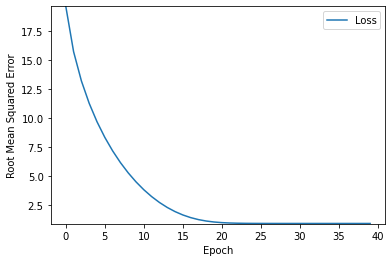

In [60]:
plot_the_loss_curve(epochs, rmse)

# ***Решение задачи классификации***

In [61]:
!ls

balance  balance.zip  dee  dee.zip  ecoli  ecoli.zip  sample_data


In [62]:
!unzip "balance.zip" -d "balance"

Archive:  balance.zip
replace balance/balance.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [63]:
FILE_PATH = '/content/balance'
MAIN_FILE_NAME = 'balance.dat'

data = load_keel('/content/balance/balance.dat')

balance = data

In [64]:
# Генерация названий строк
balance_names = np.array(['Balance{}'.format(i) for i in range(data.X.shape[0])])

In [65]:
data = pd.DataFrame(data.X, columns=data.inputs, index=balance_names)
data

,Left-weight,Left-distance,Right-weight,Right-distance
Balance0,1.0,1.0,1.0,1.0
Balance1,1.0,1.0,1.0,2.0
Balance2,1.0,1.0,1.0,3.0
Balance3,1.0,1.0,1.0,4.0
Balance4,1.0,1.0,1.0,5.0
...,...,...,...,...
Balance620,5.0,4.0,2.0,4.0
Balance621,5.0,4.0,3.0,1.0
Balance622,5.0,4.0,3.0,4.0
Balance623,5.0,5.0,3.0,4.0


*Теперь нормализуем данные*

In [66]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
data_scaled = MinMaxScaler().fit_transform(data)

In [68]:
pd.DataFrame(data_scaled, columns=balance.inputs, index=balance_names)

,Left-weight,Left-distance,Right-weight,Right-distance
Balance0,0.0,0.00,0.00,0.00
Balance1,0.0,0.00,0.00,0.25
Balance2,0.0,0.00,0.00,0.50
Balance3,0.0,0.00,0.00,0.75
Balance4,0.0,0.00,0.00,1.00
...,...,...,...,...
Balance620,1.0,0.75,0.25,0.75
Balance621,1.0,0.75,0.50,0.00
Balance622,1.0,0.75,0.50,0.75
Balance623,1.0,1.00,0.50,0.75


In [69]:
def build_model(my_learning_rate):
  """Создание классификатора"""
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(4,)))
  # Выходной слой с числом нейронов по числу классов
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Dense(4))

  # Лосс-функция уже другая 
  model.compile(optimizer=tf.optimizers.Adam(lr=my_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model  

print("Defined create_model")

Defined create_model


In [70]:
def train_model(model, feature, label, epochs, batch_size):
  """Обучение модели"""

  history = model.fit(x=feature,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  acc = hist["accuracy"]

  return trained_weight, trained_bias, epochs, acc

print("Defined train_model")

Defined train_model


In [71]:
def plot_the_loss_curve(epochs, acc):
  """График лосс-значений/эпохи"""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Sparse Categorical Crossentropy ")

  plt.plot(epochs, acc, label="Accuracy")
  plt.legend()
  plt.ylim([acc.min()*0.97, acc.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


In [72]:
x = data_scaled
y = balance.y

In [73]:
learning_rate=0.001
epochs=100
my_batch_size= 15

my_model = build_model(learning_rate)
trained_weight, trained_bias, epochs, acc = train_model(my_model, x, 
                                                        y, epochs,
                                                        my_batch_size)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


42/42 [==============================] - 0s 1ms/step - loss: 1.4393 - accuracy: 0.2848
Epoch 2/100
42/42 [==============================] - 0s 1ms/step - loss: 1.2945 - accuracy: 0.2128
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 1.1689 - accuracy: 0.4016
Epoch 4/100
42/42 [==============================] - 0s 1ms/step - loss: 1.0630 - accuracy: 0.4608
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 0.9918 - accuracy: 0.4752
Epoch 6/100
42/42 [==============================] - 0s 1ms/step - loss: 0.9487 - accuracy: 0.5248
Epoch 7/100
42/42 [==============================] - 0s 1ms/step - loss: 0.9214 - accuracy: 0.5616
Epoch 8/100
42/42 [==============================] - 0s 1ms/step - loss: 0.8994 - accuracy: 0.6144
Epoch 9/100
42/42 [==============================] - 0s 1ms/step - loss: 0.8793 - accuracy: 0.6160
Epoch 10/100
42/42 [==============================] - 0s 1ms/step - loss: 0.8571 - accuracy: 0.6656
Epoch 11/100
42/42 [=

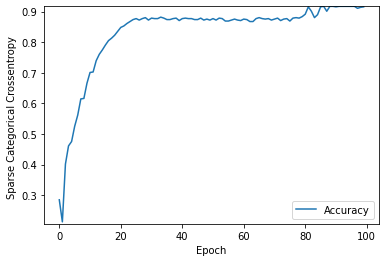

In [74]:
plot_the_loss_curve(epochs, acc)

In [75]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
dataset = fetch_openml('har')
X = StandardScaler().fit_transform(dataset.data)
Y = dataset.target
Y_new = []
for i in range(len(Y)):
  Y_new.append(int(Y[i]))

In [76]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [77]:
from sklearn.model_selection import train_test_split
features = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X[:, :features], 
    Y, 
    test_size=0.3, 
    shuffle=True)

In [78]:
kf = KFold(n_splits=5)
accs = []
for train_index, test_index in kf.split(X):
  for i in range(0, 5):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = LinearSVC(tol=1e1)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    acc = accuracy_score(predicted, y_test)
    accs.append(acc)
print(np.mean(accs))

0.9394516519943227
